In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Integrate and fire model

This is a simplified neuron model that starts from the RC-circuit model of a membrane:

$$
\tau\frac{dV}{dt} = -(V - V_{eq}) + RI(t)
$$

This model contains a parameter for the membrane resistance($R$), membrane capacitance ($C$) and equilibrium potential ($V_{eq}$). By itself this model is unable to generate any action potentials. In the integrate and fire model we define additional parameters that allows us to 'generate' spikes. 

We first define a voltage threshold $V_{thres}$. As soon as the membrane potential crosses this value we paste in a spike by setting the membrane potential momentarily (i.e., for one time step in the numerical integration of the differential equation) to a maximum voltage $v_{max}$.

We also define a reset voltage $V_{reset}$. After a spike has been emitted we manually set the voltage to this reset potential. By choosing a reset potential that is lower than the equilibrium potential we are implicitly including a refractory period because with the same input current it will now take a little longer to produce another spike. However, we could also explicitly model a refractory period by fixing the membrane potential to the reset potential for a fixed number of time steps. The following code defines the different parameter and prepares an additional current variable that is used to inject a 2.0 mA current between 200 and 400 ms.

In [20]:
R = 40.0  # Mohm
C = 1.0   # nF
tau = R*C # Membrane time constant

V_thres    = -40.0  # Threshold potential [mV]
V_max      =  40.0 # Spike potential     [mV]
V_reset    = -70.0 # Reset potential     [mV]
V_eq       = -60.0 # Resting potential   [mV]
max_refrac = 3     # time steps in refractory period

# define time variable and voltage trace
dt = 1     
t = np.arange(0,500,dt)
V_trace = np.zeros(len(t))
V_trace[0] = V_eq

# define a current trace 
I_max = 1.0
I_trace = np.zeros(len(t))
I_trace[200:400] = I_max

With the parameters defined we are now ready to run the simuluation. At each time step we first check if the neuron is in the refractory period. If so we keep the membrane potential fixed. In the case that the neuron is not in the refractory period we update the membrane potential according to the differential equation. Finally, we check if the membrane potential has crossed the threshold value and emit a spike if that is the case

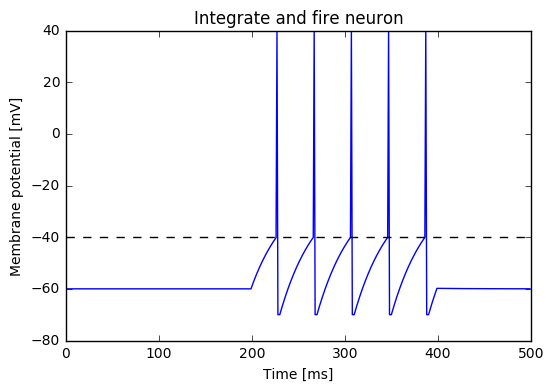

In [21]:
refrac = 0  # If larger than 0, the neuron is in the refractory period
for i in range(1,len(t)):
    # 1. Check if the neuron is in the refractory period
    if refrac > 0:
        V_trace[i] = V_reset
        refrac -= 1
        continue
    
    # 2. Update the membrane potential
    V  = V_trace[i-1]
    dv = (-(V - V_eq) + R*I_trace[i])/tau
    V_trace[i] = V + dv*dt
    
    # 3. Check for spikes
    if V_trace[i] > V_thres:
        V_trace[i] = V_max
        refrac = max_refrac

plt.plot(t,V_trace)
plt.axhline(V_thres,linestyle = '--',color='k')
plt.gca().set(xlabel='Time [ms]',ylabel='Membrane potential [mV]')
plt.title('Integrate and fire neuron')

When the equations are relatively simple, it is possible to construct a phase plane for a given differential equation. For a one-dimensional differential equation this is simply a plot of the value of the membrane potential and the corresponding value of the derivative. In the following code we do this for the case where there is no external input and for the case where there is a positive input.

[<matplotlib.text.Text at 0x8011e90>, <matplotlib.text.Text at 0x7eade70>]

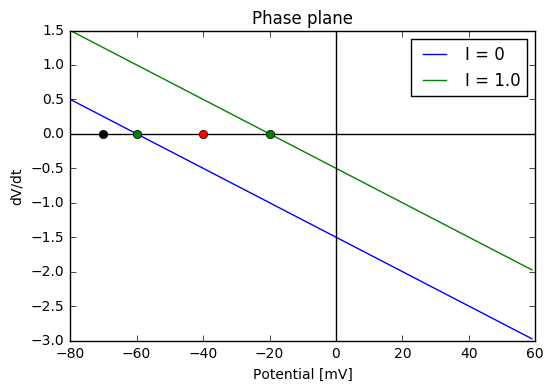

In [22]:
V = np.arange(-80,60,1)
f_V = -(V-V_eq)/tau

plt.plot(V,f_V,'b')
plt.plot(V,f_V + R*I_max/tau,'g')
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.plot(V_eq,0,'og')
plt.plot(V_eq + R*I_max,0,'og')
plt.plot(V_thres,0,'or')
plt.plot(V_reset,0,'ok')
plt.title('Phase plane')
plt.legend(['I = 0','I = ' + str(I_max)])
plt.gca().set(xlabel = 'Potential [mV]', ylabel ='dV/dt')

From this plot we can get an idea of how the system will behave when the membrane potential is at a particular value. The blue line corresponds to the system when no input current is delivered. It has a stable point that corresponds to the equilibrium potential, illustrated by the green dot on the blue line. Applying an external input has the effect that the stable point moves to the right. The behavior of the system is now described by the green line. If the system was previously at the equilibrium potential it will now be attracted toward to new stable fixed point. However, in order to get there it has to cross the threshold voltage (depicted by the red point). This means that the system will emit a spike and we will move the state to the reset potential (black dot). As long as the input current is active the system will keep emitting spikes.

## 2. Exponential integrate and fire model

The integrate and fire model abstracts away all the interesting dynamics that occur during the generation of an action potential. In real neurons there seems to be a threshold value such that when a current pulse pushes the membrane potential beyond that particular value the membrane potential will continue to increase even if there no longer is any current applied. This phenomenon can be modeled by including an exponential term in the standard integrate and fire model. The equation then becomes:

$$
\tau\frac{dV}{dt} = -(V - V_{eq}) + e^{\frac{V - V_{threshold}}{\delta_T}} + RI(t)
$$

It includes one additional parameter: $\delta_T$, that controls how quickly the membrane potential is allowed to rise again. In the following code we define this additional parameter. We then simulate a scenario where an input current is provided between 50 and 95 ms. This is done for two different current amplitudes. The first amplitude is slightly below the threshold at which the membrane potential will start to increase by itself, while the second amplitude is slightly above this value. For the numerical integration we no longer work with an explicit threshold  value because the model is now able to generate the fast rising of the action potential by itself. However, we still need to manually reset the membrane potential after it has reached some maximum value.

[<matplotlib.text.Text at 0x96c70b0>, <matplotlib.text.Text at 0x96b2530>]

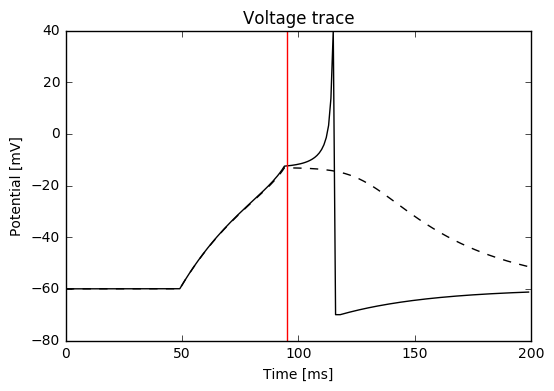

In [32]:
delta_T = 7.0

# Prepare voltage trace
t = np.arange(0,200,dt)
V_trace = np.zeros((2,len(t)))
V_trace[:,0] = V_eq

# define a current trace 
I_max = [1.49,1.50]
I_trace = np.zeros(len(t))

for i in range(2):
    I_trace[50:95] = I_max[i]
    refrac = 0 
    for j in range(1,len(t)):
        if refrac > 0:
            V_trace[i,j] = V_reset
            refrac -= 1
            continue
    
        V  = V_trace[i,j-1]
        dv = (-(V - V_eq) + np.exp((V-V_thres)/delta_T) + R*I_trace[j])/tau
        V_trace[i,j] = V + dv*dt
        
        if V_trace[i,j] > V_max:
            V_trace[i,j] = V_max
            refrac = max_refrac
        
# Plot voltage traces
plt.plot(t,V_trace[0,:],'--k')
plt.plot(t,V_trace[1,:],'k')
plt.title('Voltage trace')
plt.axvline(95,color='r')
plt.gca().set(ylabel = 'Potential [mV]', xlabel ='Time [ms]')

And once again we can construct a phase plot that gives a more abstract representation of the behavior of the system. Depending on the amplitude of the input current we can have two, one, or no fixed points. The plot shows the phase plane for a system where no current is applied (blue line). Here we have two fixed points: one stable (green) and one unstable (red). The actual values of these fixed points can be calculated using the Newton-Raphson method. As long as the membrane potential remains to the left side of the unstable point it will always be attracted to the stable fixed point, but if it crosses this point it will increase until we manually reset it. 

The green line in the plot shows the phase plane for a system that is getting some input current. As long as this input current is provided, the membrane potential will continue to increase until we manually reset it after it has crossed some maximum value. If the current is removed then the system can again be described by the blue phase curve. The behavior we observe will depend on the membrane potential at the moment we remove the current. If it is higher than the red dot an action potential will be generated and else it will return to the equilibrium potential.

[<matplotlib.text.Text at 0x8507890>, <matplotlib.text.Text at 0x8311e10>]

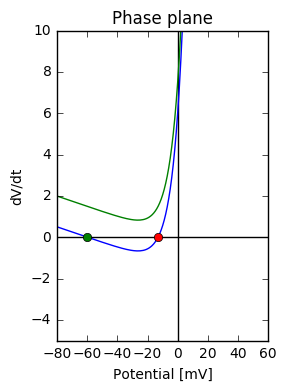

In [33]:
V = np.arange(-80.0,60.0,1.0)
f_V = (-(V-V_eq) + np.exp((V - V_thres)/delta_exp))/tau

fp_1 = -59.94
fp_2 = -13.05

plt.subplot(1,2,2)
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.plot(V,f_V)
plt.plot(V,f_V + R*I_max[0]/tau)
plt.plot(fp_1,0,'og')
plt.plot(fp_2,0,'or')
plt.ylim(-5,10)
plt.title('Phase plane')
plt.gca().set(xlabel = 'Potential [mV]', ylabel ='dV/dt')